In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from keras.preprocessing.image import ImageDataGenerator
import glob

import random
from IPython import display

from PIL import Image

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.engine.input_layer import Input

from tensorflow.keras import losses

IMG_DIMS = 256
CLASSES = [0, 85, 170, 255]

Using TensorFlow backend.


In [2]:
def plot_gallery(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray, vmax=255, vmin=0)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [3]:
def plot_metrics(history):
    # list all data in history
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [4]:
def split_masks(mask):
    classes = np.unique(mask)
    res = np.zeros(mask.shape + (len(classes),))
    for i in range(4): 
        c = classes[i]
        res [:,:,i][mask==c] = 1
    return res 

In [5]:
def check_masks(y_train, y_masks): 
    titles = []
    imgs = []
    rand_imgs_idx = random.sample(range(0, len(y_masks)), 1)

    for r in rand_imgs_idx: 
        masks = []
        mask_titles = []
        m = y_masks[r]
        _, _, c = m.shape
        
        mask_titles.append('Actual Mask')
        imgs.append(y_train[r])
        
        am = y_masks[r]            
        
        for i in range(c):
            s = am[:, :, i]
            if i == 0: 
                s[s==1] = 255
            else: 
                s[s==1] = CLASSES[i]
            masks.append(s)
            mask_titles.append('Mask %d' %i)
            
            print(np.unique(s))

        imgs += masks
        titles += mask_titles

    plot_gallery(imgs, titles, n_row=1, n_col=5)
    plt.show()

In [6]:
def check_masks_val(y_pred_masks, y_masks, threshold=0.25): 
    titles = []
    imgs = []
    rand_imgs_idx = random.sample(range(0, len(y_pred_masks)), 3)

    for r in rand_imgs_idx: 
        p_masks = []
        p_mask_titles = []
        
        a_masks = []
        a_mask_titles = []
        
        pm = y_pred_masks[r]
        am = y_masks[r]
        
        _, _, c = pm.shape
        
        p = np.zeros(pm.shape[:-1])
        a = np.zeros(pm.shape[:-1])

        for i in range(c):
            s = pm[:, :, i]
            if i > 0: 
                s[s>=threshold] = CLASSES[i]
                p+=s
            else: 
                s[s>=threshold] = 255
            p_masks.append(s)
            p_mask_titles.append('Predicted Mask %d' %i)
        
        for i in range(c):
            s = am[:, :, i]
            if i > 0: 
                s[s==1] = CLASSES[i]
                a+=s
            else: 
                s[s==1] = 255
            a_masks.append(s)
            a_mask_titles.append('Actual Mask %d' %i)
        
        imgs+= [p] + p_masks + [a] + a_masks
        titles += ['Predicted %d' %r] + p_mask_titles + ['Actual %d' %r] + a_mask_titles

    plot_gallery(imgs, titles, n_row=6, n_col=5)
    plt.show()

## Part 3 - Recognition 
### a) . UNet based magnetic resonance (MR) image segmentation of the brain via the Preprocessed OASIS dataset - Hard Difficulty
You must obtain reasonable results and be able to explain all results, network layers and code to the
demonstrator in order to obtain the marks available. Usage of pre-built models will generally not be
allowed unless approved by the demonstrator. A note of warning, GANs have very chaotic convergence and therefore difficult to train, only attempt it if you have had some previous experience in deep
learning and if you do, you do so at your own risk.

In [7]:
X_test_files = sorted(glob.glob("data/keras_png_slices_data/test/keras_png_slices_test/*.png"))
y_test_files = sorted(glob.glob("data/keras_png_slices_data/test/keras_png_slices_seg_test/*.png"))

X_train_files = sorted(glob.glob("data/keras_png_slices_data/train/keras_png_slices_train/*.png"))
y_train_files = sorted(glob.glob("data/keras_png_slices_data/train/keras_png_slices_seg_train/*.png"))

X_val_files = sorted(glob.glob("data/keras_png_slices_data/validate/keras_png_slices_validate/*.png"))
y_val_files = sorted(glob.glob("data/keras_png_slices_data/validate/keras_png_slices_seg_validate/*.png"))

In [8]:
train = list(zip(X_train_files, y_train_files))
test = list(zip(X_test_files, y_test_files))
val = list(zip(X_val_files, y_val_files))

# Shuffle training data 
random.shuffle(train)

# Load training data and labels 
X_train, y_train = zip(*train)
X_train = [np.asarray(Image.open(i)) for i in X_train]
y_train = [np.asarray(Image.open(i)) for i in y_train]

# Load testing data and labels 
X_test, y_test = zip(*test)
X_test = [np.asarray(Image.open(i)) for i in X_test]
y_test = [np.asarray(Image.open(i)) for i in y_test]

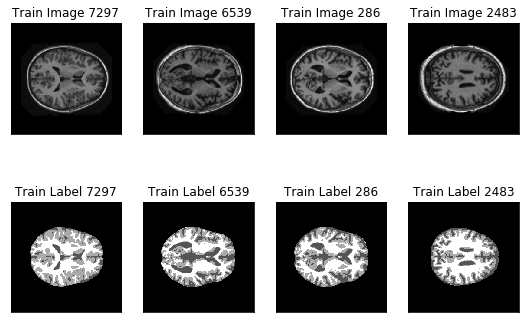

In [9]:
# Sanity check if images are the same for a few 
rand_imgs = random.sample(range(0, len(X_train)), 4)

xs = list(X_train[i] for i in rand_imgs)
ys = list(y_train[i] for i in rand_imgs)

xtitles = ["Train Image %d" % i for i in rand_imgs]
ytitles = ["Train Label %d" % i for i in rand_imgs]

plot_gallery(xs+ys, xtitles+ytitles, n_row=2, n_col=4)
plt.show()

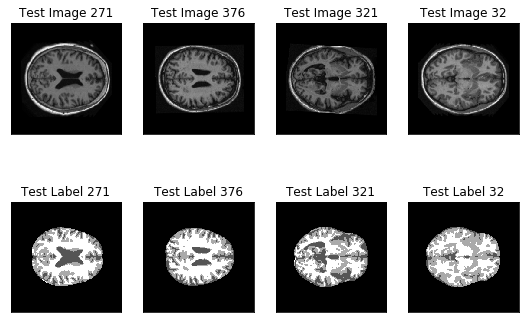

In [10]:
rand_imgs = random.sample(range(0, len(X_test)), 4)
xs = list(X_test[i] for i in rand_imgs)
ys = list(y_test[i] for i in rand_imgs)

xtitles = ["Test Image %d" % i for i in rand_imgs]
ytitles = ["Test Label %d" % i for i in rand_imgs]

plot_gallery(xs+ys, xtitles+ytitles, n_row=2, n_col=4)
plt.show()

[  0. 255.]
[ 0. 85.]
[  0. 170.]
[  0. 255.]


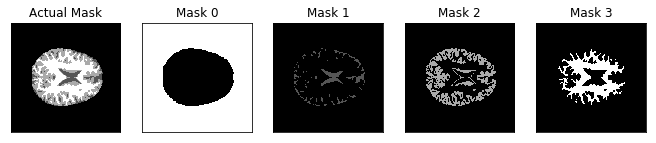

In [11]:
# Split label masks into four classes (one hot encoding)
y_train_masks = [split_masks(y) for y in y_train]
y_test_masks = [split_masks(y) for y in y_test]

check_masks(y_train, y_train_masks)

# Convert to np arrays 
X_train = np.asarray(X_train)
y_train_masks = np.asarray(y_train_masks)
X_test = np.asarray(X_test)
y_test_masks = np.asarray(y_test_masks)

# Normalise data and add dimension
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = X_train[:, :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]

In [17]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def UNet():
    kernel_size=(3,3)
    strides=1
    padding='same'
    
    f = [16, 32, 64, 128, 256]
    inputs = Input((256, 256, 1))
    
    c1 = Conv2D(16, kernel_size, padding=padding, strides=strides, activation="relu")(inputs)
    c1 = Conv2D(16, kernel_size, padding=padding, strides=strides, activation="relu")(c1)
    p1 = MaxPool2D((2, 2), (2, 2))(c1)
    
    c2 = Conv2D(32, kernel_size, padding=padding, strides=strides, activation="relu")(p1)
    c2 = Conv2D(32, kernel_size, padding=padding, strides=strides, activation="relu")(c2)
    p2 = MaxPool2D((2, 2), (2, 2))(c2)
    
    c3 = Conv2D(64, kernel_size, padding=padding, strides=strides, activation="relu")(p2)
    c3 = Conv2D(64, kernel_size, padding=padding, strides=strides, activation="relu")(c3)
    p3 = MaxPool2D((2, 2), (2, 2))(c3)
    
    c4 = Conv2D(128, kernel_size, padding=padding, strides=strides, activation="relu")(p3)
    c4 = Conv2D(128, kernel_size, padding=padding, strides=strides, activation="relu")(c4)
    p4 = MaxPool2D((2, 2), (2, 2))(c4)

    bn = Conv2D(256, kernel_size, padding=padding, strides=strides, activation="relu")(p4)
    bn = Conv2D(256, kernel_size, padding=padding, strides=strides, activation="relu")(bn)

    us1 = keras.layers.UpSampling2D((2, 2))(bn)
    concat = keras.layers.Concatenate()([us1, c4])
    u1 = Conv2D(128, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    u1 = Conv2D(128, kernel_size, padding=padding, strides=strides, activation="relu")(u1)

    us2 = keras.layers.UpSampling2D((2, 2))(u1)
    concat = keras.layers.Concatenate()([us2, c3])
    u2 = Conv2D(64, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    u2 = Conv2D(64, kernel_size, padding=padding, strides=strides, activation="relu")(u2)

    us3 = keras.layers.UpSampling2D((2, 2))(u2)
    concat = keras.layers.Concatenate()([us3, c2])
    u3 = Conv2D(32, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    u3 = Conv2D(32, kernel_size, padding=padding, strides=strides, activation="relu")(u3)
    
    us4 = keras.layers.UpSampling2D((2, 2))(u3)
    concat = keras.layers.Concatenate()([us4, c1])
    u4 = Conv2D(16, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    u4 = Conv2D(16, kernel_size, padding=padding, strides=strides, activation="relu")(u4)

#     c1, p1 = down_block(inputs, f[0]) #128 -> 64
#     c2, p2 = down_block(p1, f[1]) #64 -> 32
#     c3, p3 = down_block(p2, f[2]) #32 -> 16
#     c4, p4 = down_block(p3, f[3]) #16 -> 8
    
#     bn = bottleneck(p4, f[4])
    
#     u1 = up_block(bn, c4, f[3]) #8 -> 16
#     u2 = up_block(u1, c3, f[2]) #16 -> 32
#     u3 = up_block(u2, c2, f[1]) #32 -> 64
#     u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = Conv2D(4, (1, 1), padding="same", activation="softmax")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [18]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
#model.summary()

In [31]:
history = model.fit(
    X_train[:70], y_train_masks[:70], 
    batch_size=8,
    validation_data=(X_test[:10], y_test_masks[:10]), 
    epochs=20,
    shuffle=True)

Train on 70 samples, validate on 10 samples
Epoch 1/20
70/70 [==============================] - 26s 376ms/step - loss: 0.1395 - acc: 0.9388 - val_loss: 0.1406 - val_acc: 0.9394
Epoch 2/20
70/70 [==============================] - 25s 364ms/step - loss: 0.1248 - acc: 0.9409 - val_loss: 0.1320 - val_acc: 0.9336
Epoch 3/20
70/70 [==============================] - 26s 366ms/step - loss: 0.1262 - acc: 0.9361 - val_loss: 0.1427 - val_acc: 0.9227
Epoch 4/20
70/70 [==============================] - 25s 364ms/step - loss: 0.1152 - acc: 0.9437 - val_loss: 0.1157 - val_acc: 0.9405
Epoch 5/20
70/70 [==============================] - 26s 368ms/step - loss: 0.1051 - acc: 0.9487 - val_loss: 0.1056 - val_acc: 0.9511
Epoch 6/20
70/70 [==============================] - 26s 369ms/step - loss: 0.0950 - acc: 0.9595 - val_loss: 0.1405 - val_acc: 0.9228
Epoch 7/20
70/70 [==============================] - 26s 372ms/step - loss: 0.1103 - acc: 0.9468 - val_loss: 0.1278 - val_acc: 0.9366
Epoch 8/20
70/70 [=======

### Inference on validation set 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


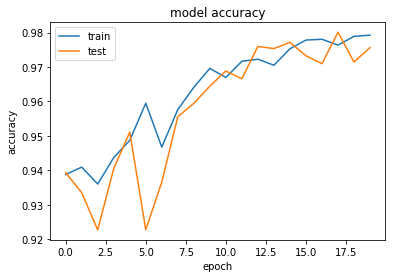

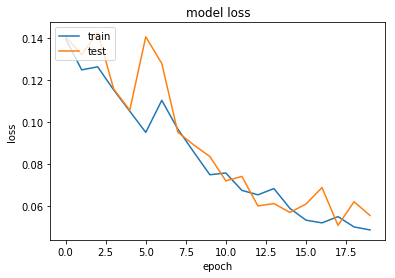

In [32]:
plot_metrics(history)

In [21]:
# Load testing data and labels 
X_val, y_val = zip(*test)
X_val = [np.asarray(Image.open(i)) for i in X_val]
y_val = [np.asarray(Image.open(i)) for i in y_val]

y_val_masks = [split_masks(y) for y in y_val]

# Convert to np arrays 
X_val = np.asarray(X_val)
y_val_masks = np.asarray(y_val_masks)

# Normalise and add dimension
X_val = X_val / 255.0
X_val = X_val[:, :, :, np.newaxis]

In [34]:
test_lost, test_acc = model.evaluate(X_val[:2], y_val_masks[:2])
print('Test accuracy: ', test_acc)

2/2 [==============================] - 0s 138ms/step
Test accuracy:  0.7382907867431641


In [35]:
y_preds = model.predict(X_val[:5])

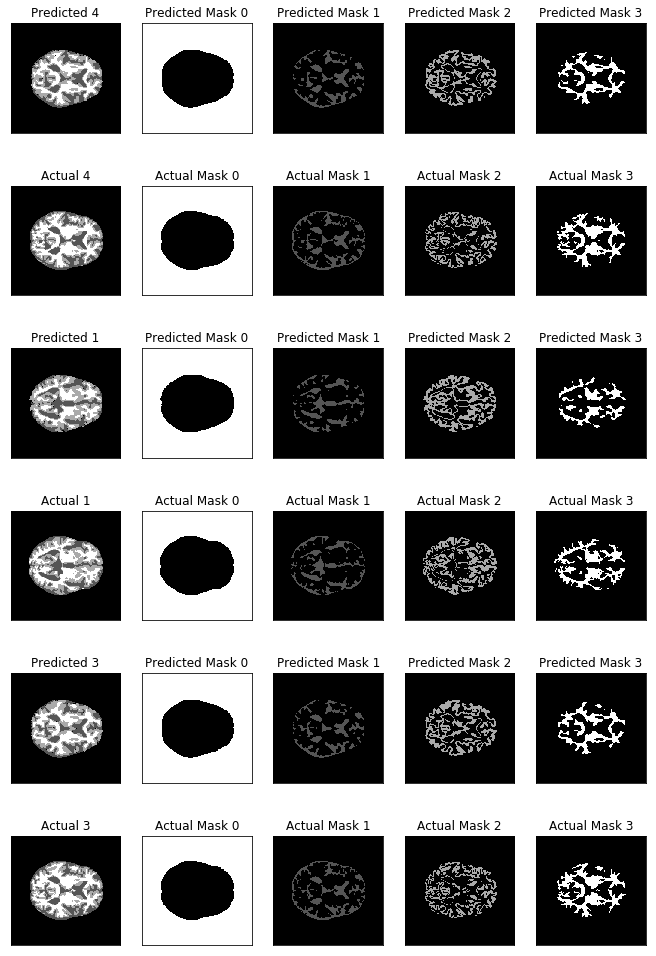

In [38]:
# Visualisation of masks predicted 
check_masks_val(y_preds[:5], y_val_masks[:5], threshold=0.5)